### Section 0: Imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score


### Section 1: Task 1 - Dataset Exploration

In [10]:
diabetes = load_diabetes()

X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target, name="target")

print("=== Dataset Shapes ===")
print("X shape:", X.shape)
print("y shape:", y.shape)

print("\n=== Feature Names ===")
print(list(X.columns))

print("\n=== X Summary Statistics ===")
print(X.describe())

print("\n=== Target Summary Statistics ===")
print(y.describe())

# 80-20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\n=== Train/Test Shapes ===")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

=== Dataset Shapes ===
X shape: (442, 10)
y shape: (442,)

=== Feature Names ===
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

=== X Summary Statistics ===
                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670422e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564379e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320436e-01  1.539137e-01   

                 s2            s3            s4            s5            s6  
count  4.420000e+02  4.420000e+02  

### Section 2: Task 2 - Baseline Linear Regression Model

In [11]:
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print("\n=== Baseline Linear Regression ===")
print("Baseline R2:", baseline_r2)

# Rank initial feature importance by absolute coefficient magnitude
baseline_coef = pd.Series(baseline_model.coef_, index=X.columns)
baseline_rank = baseline_coef.abs().sort_values(ascending=False)

print("\n=== Baseline Coefficients ===")
print(baseline_coef.sort_values(ascending=False))

print("\n=== Baseline Feature Ranking (abs coef) ===")
print(baseline_rank)


=== Baseline Linear Regression ===
Baseline R2: 0.4526027629719196

=== Baseline Coefficients ===
s5     736.198859
bmi    542.428759
s2     518.062277
bp     347.703844
s4     275.317902
s3     163.419983
s6      48.670657
age     37.904021
sex   -241.964362
s1    -931.488846
dtype: float64

=== Baseline Feature Ranking (abs coef) ===
s1     931.488846
s5     736.198859
bmi    542.428759
s2     518.062277
bp     347.703844
s4     275.317902
sex    241.964362
s3     163.419983
s6      48.670657
age     37.904021
dtype: float64


### Section 3: Task 3 - Recursive Feature Elimination (RFE)
###   - Track R2 at each iteration
###   - Track coefficients at each iteration

In [12]:
r2_scores = []
feature_counts = []
coef_history = []
selected_features_history = []

for n_features in range(X.shape[1], 0, -1):  # 10 down to 1
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=n_features, step=1)
    rfe.fit(X_train, y_train)

    # Transform datasets
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Fit model on selected features
    model = LinearRegression()
    model.fit(X_train_rfe, y_train)

    # Evaluate
    y_pred = model.predict(X_test_rfe)
    r2 = r2_score(y_test, y_pred)

    # Store results
    r2_scores.append(r2)
    feature_counts.append(n_features)

    # Store coefficients mapped back to original feature list
    coefs_full = np.zeros(X.shape[1])
    coefs_full[rfe.support_] = model.coef_
    coef_history.append(coefs_full)

    # Store which features were selected at this step
    selected_features_history.append(list(X.columns[rfe.support_]))

print("\n=== RFE Results (R2 by number of features) ===")
for k, r2 in zip(feature_counts, r2_scores):
    print(f"{k:2d} features -> R2 = {r2:.4f}")


=== RFE Results (R2 by number of features) ===
10 features -> R2 = 0.4526
 9 features -> R2 = 0.4587
 8 features -> R2 = 0.4559
 7 features -> R2 = 0.4583
 6 features -> R2 = 0.4628
 5 features -> R2 = 0.4382
 4 features -> R2 = 0.4464
 3 features -> R2 = 0.4451
 2 features -> R2 = 0.4523
 1 features -> R2 = 0.2334


### Section 4: Task 3.4 - Visualization (R2 vs #Features)

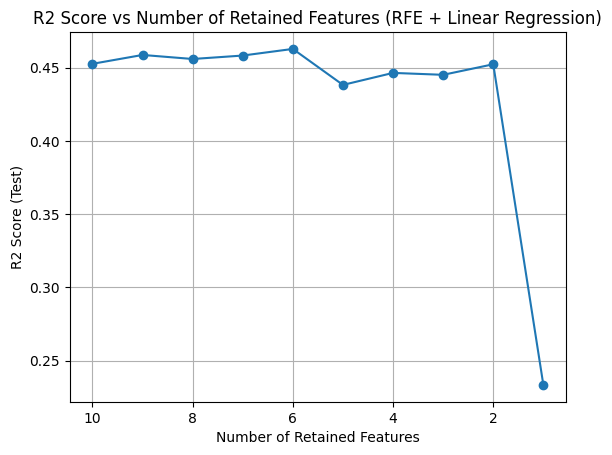

In [13]:
plt.figure()
plt.plot(feature_counts, r2_scores, marker="o")
plt.xlabel("Number of Retained Features")
plt.ylabel("R2 Score (Test)")
plt.title("R2 Score vs Number of Retained Features (RFE + Linear Regression)")
plt.gca().invert_xaxis()  # show 10 on left -> 1 on right
plt.grid(True)
plt.show()

### Section 5: Task 3.5 - Optimal #Features using threshold (0.01)
### Logic:
### - We reduce features from 10 -> 1.
### - If removing one feature causes an R2 drop > threshold, we stop.
### - Choose the previous (larger) feature count as "optimal".

In [14]:
threshold = 0.01
optimal_k = feature_counts[0]  # default to 10 if nothing drops significantly

for i in range(1, len(r2_scores)):
    drop = r2_scores[i - 1] - r2_scores[i]  # positive means performance got worse
    if drop > threshold:
        optimal_k = feature_counts[i - 1]  # previous number of features
        break

print("\n=== Optimal Feature Count (Threshold = 0.01) ===")
print("Optimal number of features:", optimal_k)


=== Optimal Feature Count (Threshold = 0.01) ===
Optimal number of features: 6


### Section 6: Task 4.1 - Coefficient Table at Each Iteration
### Rows = number of features retained; Columns = original feature names

In [15]:
coef_df = pd.DataFrame(
    coef_history,
    columns=X.columns,
    index=feature_counts
).sort_index(ascending=False)

print("\n=== Coefficient Table (each RFE iteration) ===")
print(coef_df)


=== Coefficient Table (each RFE iteration) ===
          age         sex         bmi          bp          s1          s2  \
10  37.904021 -241.964362  542.428759  347.703844 -931.488846  518.062277   
9    0.000000 -236.649588  542.799508  354.211438 -936.350589  528.796592   
8    0.000000 -233.754686  550.744365  363.791753 -947.823133  541.585796   
7    0.000000 -235.364224  551.866448  362.356114 -660.643160  343.348089   
6    0.000000 -215.267423  557.314167  350.178667 -851.515734  591.093315   
5    0.000000    0.000000  597.892739  306.647913 -655.560612  409.622184   
4    0.000000    0.000000  691.460102    0.000000 -592.977874  362.950323   
3    0.000000    0.000000  737.685594    0.000000 -228.339889    0.000000   
2    0.000000    0.000000  732.109021    0.000000    0.000000    0.000000   
1    0.000000    0.000000  998.577689    0.000000    0.000000    0.000000   

            s3          s4          s5         s6  
10  163.419983  275.317902  736.198859  48.670657  


### Section 7: Task 4.2 - Three Most Important Features Discussion Data
### Use the optimal_k run to identify selected features

In [16]:
rfe_opt = RFE(estimator=LinearRegression(), n_features_to_select=optimal_k, step=1)
rfe_opt.fit(X_train, y_train)

selected_opt = list(X.columns[rfe_opt.support_])
ranking_opt = pd.Series(rfe_opt.ranking_, index=X.columns).sort_values()

print("\n=== Features Selected at Optimal K ===")
print(selected_opt)

print("\n=== RFE Ranking (1 = selected, higher = eliminated earlier) ===")
print(ranking_opt)


=== Features Selected at Optimal K ===
['sex', 'bmi', 'bp', 's1', 's2', 's5']

=== RFE Ranking (1 = selected, higher = eliminated earlier) ===
sex    1
bmi    1
bp     1
s1     1
s2     1
s5     1
s4     2
s3     3
s6     4
age    5
dtype: int64


In [17]:
# Fit final model at optimal_k and show coefficients for selected features
X_train_opt = rfe_opt.transform(X_train)
X_test_opt = rfe_opt.transform(X_test)

final_model = LinearRegression()
final_model.fit(X_train_opt, y_train)

y_pred_opt = final_model.predict(X_test_opt)
final_r2 = r2_score(y_test, y_pred_opt)

final_coef = pd.Series(final_model.coef_, index=selected_opt).sort_values(key=np.abs, ascending=False)

print("\n=== Final Model at Optimal K ===")
print("Final R2:", final_r2)

print("\n=== Final Coefficients (sorted by abs value) ===")
print(final_coef)

top3 = list(final_coef.index[:3])
print("\n=== Top 3 Features (by abs coefficient, optimal model) ===")
print(top3)


=== Final Model at Optimal K ===
Final R2: 0.46277670793202996

=== Final Coefficients (sorted by abs value) ===
s1    -851.515734
s5     803.121285
s2     591.093315
bmi    557.314167
bp     350.178667
sex   -215.267423
dtype: float64

=== Top 3 Features (by abs coefficient, optimal model) ===
['s1', 's5', 's2']


### Section 8: Task 4.3 - Compare Baseline Ranking vs Final Selected

In [18]:
print("\n=== Baseline Top 10 (abs coef) ===")
print(list(baseline_rank.index))

print("\n=== Final Selected Features (optimal_k) ===")
print(selected_opt)



=== Baseline Top 10 (abs coef) ===
['s1', 's5', 'bmi', 's2', 'bp', 's4', 'sex', 's3', 's6', 'age']

=== Final Selected Features (optimal_k) ===
['sex', 'bmi', 'bp', 's1', 's2', 's5']
